## **예습 코드**

[실습명: 어텐션을 사용한 인공 신경망 기계 번역]
- http://www.manythings.org/anki/ 에서 제공한 언어 데이터셋을 사용.

- 이 노트북은 스페인어를 영어로 변역하기 위해 시퀀스-투-시퀀스 (seq2seq) 모델을 훈련시킵니다. 또한 이 노트북은 시퀀스-투-시퀀스 모델의 사전적인 지식을 요구하는 심화된 예제입니다.

- 이 노트북에서 신경망 기계 번역 모델을 훈련하면 *"¿todavia estan en casa?"*와 같은 스페인 문장을 입력했을 때 *"are you still at home?"*처럼 영어로 번역된 문장을 얻을 수 있을 것입니다

- 아래의 플롯은 모델을 훈련하는 동안에 입력 문장의 각 단어가 갖고 있는 모델 어텐션을 시각화하여 보여준 것입니다:

<img src="https://tensorflow.org/images/spanish-english.png" alt="spanish-english attention plot">


In [ ]:
import tensorflow as tf

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from sklearn.model_selection import train_test_split

import unicodedata
import re
import numpy as np
import os
import io
import time

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### 데이터셋 준비

http://www.manythings.org/anki/ 에서 제공한 언어 데이터셋을 사용할 것입니다. 이 데이터셋은 언어 번역의 쌍이 다음과 같은 형식으로 포함되어 있습니다:

```
May I borrow this book?	¿Puedo tomar prestado este libro?
```

다양한 언어가 이용가능하지만 이 예제에서는 영어-스페인 데이터셋을 사용할 것입니다. 편의를 위해서 이 데이터셋의 복사본을 Google Cloud에서 호스팅 했지만 직접 다운로드해야 합니다. 데이터셋을 다운로드한 후에 데이터를 준비하고자 다음의 단계를 수행합니다.

1. 각 문장에 *start*와 *end* 토큰을 추가합니다.
2. 특정 문자를 제거함으로써 문장을 정리합니다.
3. 단어 인덱스와 아이디(ID) 인덱스를 생성합니다. (단어 → 아이디(ID), 아이디(ID) → 단어로 매핑된 딕셔너리).
4. 각 문장을 입력층의 최대 길이만큼 패딩(padding)을 수행합니다.

In [ ]:
# 파일을 다운로드 > 압축 해제
path_to_zip = tf.keras.utils.get_file(
    'spa-eng.zip', origin='http://storage.googleapis.com/download.tensorflow.org/data/spa-eng.zip',
    extract=True)

# 파일 경로 설정
path_to_file = os.path.dirname(path_to_zip)+"/spa-eng/spa.txt"

2638744/2638744 [==============================] - 1s 0us/step


In [ ]:
# 유니코드 파일을 아스키 코드 파일로 변환
# unicodedata.normalize('NFD', s): 문자와 발음 기호(악센트)를 분리하는 Normalization Form D 정규화
# Mn: Mark, Nonspacing 범주. 발음 기호 같은 비공간 마크를 나타냄. 아스키로 변환할 필요 X.
def unicode_to_ascii(s):
    return ''.join(c for c in unicodedata.normalize('NFD', s)
                  if unicodedata.category(c) != 'Mn')

def preprocess_sentence(w):
    w = unicode_to_ascii(w.lower().strip())

    # 단어와 단어 뒤에 오는 구두점(.) 사이에 공백을 생성
    # 예시: "he is a boy." => "he is a boy ."
    # 참고: https://stackoverflow.com/questions/3645931/python-padding-punctuation-with-white-spaces-keeping-punctuation
    w = re.sub(r"([?.!,¿])", r" \1 ", w)
    # 하나 이상의 공백이나 쌍따옴표는 단일 공백으로 변환
    w = re.sub(r'[" "]+', " ", w)

    # (a-z, A-Z, ".", "?", "!", ",")을 제외한 모든 것을 공백으로 대체합니다.
    w = re.sub(r"[^a-zA-Z?.!,¿]+", " ", w)

    w = w.strip()

    # 모델이 예측을 시작하거나 중단할 때를 알게 하기 위해서
    # 문장에 start와 end 토큰을 추가합니다.
    w = '<start> ' + w + ' <end>'
    return w

In [ ]:
# u: 유니코드로 인코딩됨을 표시
en_sentence = u"May I borrow this book?"
sp_sentence = u"¿Puedo tomar prestado este libro?"
print(preprocess_sentence(en_sentence))
print(preprocess_sentence(sp_sentence).encode('utf-8'))

<start> may i borrow this book ? <end>
b'<start> \xc2\xbf puedo tomar prestado este libro ? <end>'


In [ ]:
def create_dataset(path, num_examples):
    # 파일의 내용을 줄 단위로 나눈다
    lines = io.open(path, encoding='UTF-8').read().strip().split('\n')

    # 각 줄에는 영어, 스페인어가 탭으로 나눠져 있다.
    # [[영어1, 스페인어1], [영어2, 스페인어2]]
    word_pairs = [[preprocess_sentence(w) for w in l.split('\t')] for l in lines[:num_examples]]

    # [(영어1, 스페인어1), (영어2, 스페인어2)]
    return zip(*word_pairs)

In [ ]:
en, sp = create_dataset(path_to_file, None)
print(en[-1])
print(sp[-1])

<start> if you want to sound like a native speaker , you must be willing to practice saying the same sentence over and over in the same way that banjo players practice the same phrase over and over until they can play it correctly and at the desired tempo . <end>
<start> si quieres sonar como un hablante nativo , debes estar dispuesto a practicar diciendo la misma frase una y otra vez de la misma manera en que un musico de banjo practica el mismo fraseo una y otra vez hasta que lo puedan tocar correctamente y en el tiempo esperado . <end>


In [ ]:
def tokenize(lang):
    # Tokenizer 객체 생성
    # 기본 필터링 (문장 부호 제거 등)을 비활성화
    lang_tokenizer = tf.keras.preprocessing.text.Tokenizer(filters='')
    # Tokenizer 학습
    lang_tokenizer.fit_on_texts(lang)
    # 텍스트를 시퀀스로 변환
    tensor = lang_tokenizer.texts_to_sequences(lang)
    # 시퀀스 패딩
    tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor, padding='post')

    return tensor, lang_tokenizer

In [ ]:
def load_dataset(path, num_examples=None):
    # 전처리된 타겟 문장과 입력 문장 쌍을 생성
    # [(영어1, 스페인어1), (영어2, 스페인어2)]
    targ_lang, inp_lang = create_dataset(path, num_examples)

    input_tensor, inp_lang_tokenizer = tokenize(inp_lang)
    target_tensor, targ_lang_tokenizer = tokenize(targ_lang)

    return input_tensor, target_tensor, inp_lang_tokenizer, targ_lang_tokenizer

###  더 빠른 실행을 위해 데이터셋의 크기 제한하기(선택)

10만개 이상의 문장이 있는 완전한 데이터셋을 훈련하는 것은 오랜 시간이 걸립니다. 훈련 속도를 높이기 위해서 데이터셋의 크기를 3만개의 문장으로 제한합니다. (물론, 번역의 질은 데이터가 적어질수록 저하됩니다):

In [ ]:
# 언어 데이터셋을 아래의 크기로 제한하여 훈련과 검증을 수행합니다.
num_examples = 30000
input_tensor, target_tensor, inp_lang, targ_lang = load_dataset(path_to_file, num_examples)

# 타겟 텐서와 입력 텐서의 최대 길이를 계산합니다.
max_length_targ, max_length_inp = target_tensor.shape[1], input_tensor.shape[1]

In [ ]:
print(target_tensor.shape)
print(input_tensor.shape)

(30000, 11)
(30000, 16)


In [ ]:
# 훈련 집합과 검증 집합을 80대 20으로 분리합니다.
input_tensor_train, input_tensor_val, target_tensor_train, target_tensor_val = train_test_split(input_tensor, target_tensor, test_size=0.2)

# 훈련 집합과 검증 집합의 데이터 크기를 출력합니다.
print(len(input_tensor_train), len(target_tensor_train), len(input_tensor_val), len(target_tensor_val))

24000 24000 6000 6000


In [ ]:
input_tensor_train

array([[   1,  769, 1756, ...,    0,    0,    0],
       [   1,  120,   16, ...,    0,    0,    0],
       [   1,    9,  131, ...,    0,    0,    0],
       ...,
       [   1,   12,   40, ...,    0,    0,    0],
       [   1,    6,    8, ...,    0,    0,    0],
       [   1,  281,   19, ...,    0,    0,    0]], dtype=int32)

In [ ]:
def convert(lang, tensor):
    for t in tensor:
        # 실제 단어에 해당하는 인덱스인 경우, 인덱스와 해당 단어를 출력
        if t != 0:
            print ("%d ----> %s" % (t, lang.index_word[t]))

In [ ]:
print ("Input Language; index to word mapping")
convert(inp_lang, input_tensor_train[0])
print ()
print ("Target Language; index to word mapping")
convert(targ_lang, target_tensor_train[0])

Input Language; index to word mapping
1 ----> <start>
769 ----> intenta
1756 ----> pararme
3 ----> .
2 ----> <end>

Target Language; index to word mapping
1 ----> <start>
125 ----> try
15 ----> to
86 ----> stop
17 ----> me
3 ----> .
2 ----> <end>


### tf.data 데이터셋 생성하기

In [ ]:
# 데이터셋을 섞을 때 사용되는 버퍼의 크기
BUFFER_SIZE = len(input_tensor_train)
BATCH_SIZE = 64
steps_per_epoch = len(input_tensor_train) // BATCH_SIZE
embedding_dim = 256
units = 1024
# +1 : 패딩 토큰을 위한 추가 인덱스 포함
vocab_inp_size = len(inp_lang.word_index) + 1
vocab_tar_size = len(targ_lang.word_index) + 1

# tf.data.Dataset 객체로 변환
# 데이터셋의 각 요소가 튜플 (입력 텐서, 타겟 텐서)로 이루어진 형태
# BUFFER_SIZE로 전체 데이터셋을 섞고, 이 버퍼에 모든 데이터를 저장
dataset = tf.data.Dataset.from_tensor_slices((input_tensor_train, target_tensor_train)).shuffle(BUFFER_SIZE)
# 배치 크기로 데이터를 나누기
# drop_remainder=True: 마지막 배치가 배치 크기보다 작으면 이 배치를 버린다
dataset = dataset.batch(BATCH_SIZE, drop_remainder=True)

In [ ]:
print(vocab_inp_size)

9414


In [ ]:
# iter(dataset): dataset 객체를 반복 가능한 객체로 변환
# next: 데이터셋의 첫 번째 배치를 가져온다
example_input_batch, example_target_batch = next(iter(dataset))
example_input_batch.shape, example_target_batch.shape

(TensorShape([64, 16]), TensorShape([64, 11]))

## 인코더 모델과 디코더 모델 쓰기

어텐션(attention)을 가진 인코더-디코더 모델을 수행합니다. 어텐션(attention)은 TensorFlow [Neural Machine Translation (seq2seq) tutorial](https://github.com/tensorflow/nmt)에서 읽을 수 있습니다. 이 예제는 더 최신의 API 집합을 사용합니다. 이 노트북은 seq2seq 튜토리얼로부터 [어텐션 방정식](https://github.com/tensorflow/nmt#background-on-the-attention-mechanism)을 수행합니다. 아래의 다이어그램은 각각의 입력 단어가 어텐션 메커니즘에 의해 가중치가 할당된 모습입니다. 이러한 어텐션 메커니즘은 디코더가 문장에서 다음 단어를 예측하기 위해 사용됩니다. 아래의 그림과 공식은 [Luong's paper](https://arxiv.org/abs/1508.04025v5)에서 나온 어텐션 메커니즘의 예시입니다.

<img src="https://www.tensorflow.org/images/seq2seq/attention_mechanism.jpg" width="500" alt="attention mechanism">

입력은 *(batch_size, max_length, hidden_size)*의 형태로 이루어진 인코더 결과와 *(batch_size, hidden_size)*쌍으로 이루어진 인코더 은닉 상태(hidden state)를 제공하는 인코더 모델을 통해 입력됩니다.

아래의 공식은 위에서 사용한 방정식을 나타낸 것이다:

<img src="https://www.tensorflow.org/images/seq2seq/attention_equation_0.jpg" alt="attention equation 0" width="800">
<img src="https://www.tensorflow.org/images/seq2seq/attention_equation_1.jpg" alt="attention equation 1" width="800">

이 튜토리얼은 인코더를 위해 [Bahdanau 어텐션](https://arxiv.org/pdf/1409.0473.pdf)을 사용합니다. 단순화된 형태로 쓰기 전에 표기법을 아래와 같이 정의합니다:

* FC = 완전 연결(Dense)층
* EO = 인코더 결과
* H = 은닉 상태(hidden state)
* X = 디코더에 대한 입력

그리고 다음은 슈도코드입니다:

* `스코어(score)는 FC(tanh(FC(EO) + FC(H)))`로 계산합니다.
* `어텐션 가중치는 softmax(score, axis = 1)`로 계산합니다. 기본적으로 소프트맥스는 마지막 축을 적용하지만 스코어(score)의 형태가 *(batch_size, max_length, hidden_size)*이기 때문에 *첫번째 축*을 적용합니다. `Max_length`은 입력의 길이입니다. 각각의 입력에 가중치를 할당하려고 시도하기 때문에 소프트맥스는 그 축을 적용할 수 있습니다.
* `컨텍스트 벡터(context vector)는 sum(어텐션 가중치 * EO, axis = 1)`로 계산합니다. 위와 같은 이유로 첫번째 축을 선택합니다.
* `임베딩 결과(embedding output)`는 디코더 X에 대한 입력이 임베딩층을 통과한 결과입니다.
* `병합된 벡터(merged vector)는 concat(임베딩 결과, 컨텍스트 백터(context vector))`와 같습니다.
* 그런 다음 병합된 벡터는 GRU에 주어집니다.

매 단계마다 모든 벡터의 형태는 코드내 주석에 명시되어 있습니다:

In [ ]:
class Encoder(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, enc_units, batch_sz):
        super(Encoder, self).__init__()
        self.batch_sz = batch_sz  # batch size
        self.enc_units = enc_units  # GRU 셀의 hidden state 차원 수

        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        self.gru = tf.keras.layers.GRU(self.enc_units,
                                       return_sequences=True,  # 시퀀스의 모든 timestep 출력 반환
                                       return_state=True,  # 최종 상태 반환
                                       recurrent_initializer='glorot_uniform')  #GRU 가중치 초기화

    def call(self, x, hidden):  # hidden: 초기 hidden state
        x = self.embedding(x)
        # output: 인코더의 출력 시퀀스 (각 단어의 hidden state를 모은 것)
        # state: 인코더의 최종 hidden state
        output, state = self.gru(x, initial_state = hidden)
        return output, state

    # GRU 셀의 초기 hidden state 생성
    def initialize_hidden_state(self):
        return tf.zeros((self.batch_sz, self.enc_units))

In [ ]:
encoder = Encoder(vocab_inp_size, embedding_dim, units, BATCH_SIZE)

# 샘플 입력
sample_hidden = encoder.initialize_hidden_state()
sample_output, sample_hidden = encoder(example_input_batch, sample_hidden)
print ('Encoder output shape: (batch size, sequence length, units) {}'.format(sample_output.shape))
print ('Encoder Hidden state shape: (batch size, units) {}'.format(sample_hidden.shape))

Encoder output shape: (batch size, sequence length, units) (64, 16, 1024)
Encoder Hidden state shape: (batch size, units) (64, 1024)


In [ ]:
class BahdanauAttention(tf.keras.layers.Layer):
    def __init__(self, units):
        super(BahdanauAttention, self).__init__()
        self.W1 = tf.keras.layers.Dense(units)
        self.W2 = tf.keras.layers.Dense(units)
        self.V = tf.keras.layers.Dense(1)

    def call(self, query, values):
        # 쿼리 은닉 상태(query hidden state)는 (batch_size, hidden size)쌍으로 이루어져 있습니다.
        # query_with_time_axis은 (batch_size, 1, hidden size)쌍으로 이루어져 있습니다.
        # values는 (batch_size, max_len, hidden size)쌍으로 이루어져 있습니다.
        # 스코어(score)계산을 위해 덧셈을 수행하고자 시간 축을 확장하여 아래의 과정을 수행합니다.
        query_with_time_axis = tf.expand_dims(query, 1)

        # score는 (batch_size, max_length, 1)쌍으로 이루어져 있습니다.
        # score를 self.V에 적용하기 때문에 마지막 축에 1을 얻습니다.
        # self.V에 적용하기 전에 텐서는 (batch_size, max_length, units)쌍으로 이루어져 있습니다.
        score = self.V(tf.nn.tanh(
                       self.W1(query_with_time_axis) + self.W2(values)))

        # attention_weights는 (batch_size, max_length, 1)쌍으로 이루어져 있습니다.
        attention_weights = tf.nn.softmax(score, axis=1)

        # 덧셈이후 컨텍스트 벡터(context_vector)는 (batch_size, hidden_size)쌍으로 이루어져 있습니다.
        context_vector = attention_weights * values
        context_vector = tf.reduce_sum(context_vector, axis=1)

        return context_vector, attention_weights

- query hidden state: (N, H)
- query_with_time_axis: (N, 1, H)
- values: (N, T, H)
- self.V 적용 전: (N, T, H)
- score: (N, T, 1)
- attention_weights: (N, T, 1)
- context_vector: (N, H)

In [ ]:
attention_layer = BahdanauAttention(1024)
attention_result, attention_weights = attention_layer(sample_hidden, sample_output)

print("Attention result shape: (batch size, units) {}".format(attention_result.shape))
print("Attention weights shape: (batch_size, sequence_length, 1) {}".format(attention_weights.shape))

Attention result shape: (batch size, units) (64, 1024)
Attention weights shape: (batch_size, sequence_length, 1) (64, 16, 1)


In [ ]:
class Decoder(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, dec_units, batch_sz):
        super(Decoder, self).__init__()
        self.batch_sz = batch_sz
        self.dec_units = dec_units  # GRU 셀의 hidden state 차원 수

        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        self.gru = tf.keras.layers.GRU(self.dec_units,
                                    return_sequences=True,
                                    return_state=True,
                                    recurrent_initializer='glorot_uniform')
        self.fc = tf.keras.layers.Dense(vocab_size)

        # 어텐션을 사용합니다.
        self.attention = BahdanauAttention(self.dec_units)


    def call(self, x, hidden, enc_output):
        # enc_output는 (batch_size, max_length, hidden_size)쌍으로 이루어져 있습니다.
        context_vector, attention_weights = self.attention(hidden, enc_output)

        # 임베딩층을 통과한 후 x는 (batch_size, 1, embedding_dim)쌍으로 이루어져 있습니다.
        x = self.embedding(x)

        # 컨텍스트 벡터와 임베딩 결과를 결합한 이후 x의 형태는 (batch_size, 1, embedding_dim + hidden_size)쌍으로 이루어져 있습니다.
        x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1)

        # 위에서 결합된 벡터를 GRU에 전달합니다.
        output, state = self.gru(x)

        # output은 (batch_size * 1, hidden_size)쌍으로 이루어져 있습니다.
        output = tf.reshape(output, (-1, output.shape[2]))

        # output은 (batch_size, vocab)쌍으로 이루어져 있습니다.
        x = self.fc(output)

        return x, state, attention_weights

In [ ]:
decoder = Decoder(vocab_tar_size, embedding_dim, units, BATCH_SIZE)

sample_decoder_output, _, _ = decoder(tf.random.uniform((BATCH_SIZE, 1)),
                                      sample_hidden, sample_output)

print ('Decoder output shape: (batch_size, vocab size) {}'.format(sample_decoder_output.shape))

Decoder output shape: (batch_size, vocab size) (64, 4935)


## 최적화 함수와 손실 함수 정의하기

In [ ]:
optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
              from_logits=True,  # 예측값이 softmax 적용 전의 raw logits
              reduction='none')  # 배치 내 각 샘플의 손실을 개별적으로 계산하여 반환

def loss_function(real, pred):
    # 실제 레이블이 0(패딩 토큰)이 아닌 경우를 찾기 위해 마스크를 생성
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    # 각 샘플에 대해 손실 계산
    loss_ = loss_object(real, pred)

    # 패딩 토큰에 해당하는 손실을 무시
    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask

    # 배치 내 모든 샘플의 평균 손실을 반환
    return tf.reduce_mean(loss_)

## 체크포인트 (객체 기반 저장)

In [ ]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(optimizer=optimizer,
                                 encoder=encoder,
                                 decoder=decoder)

## 언어 모델 훈련하기

1. *인코더 결과*와 *인코더 은닉 상태(hidden state)*를 반환하는 *인코더*를 통해서 *입력*을 전달합니다.
2. 인코더 결과, 인코더 은닉 상태(hidden state), 디코더 입력 (*start 토큰*)을 디코더에 전달합니다.
3. 전달 받은 값을 통해 디코더는 *예측 값*과 *디코더 은닉 상태(hidden state)*를 반환합니다.
4. 그 다음에 디코더 은닉 상태(hidden state)가 다시 모델에 전달되고 예측 값을 사용하여 손실을 계산합니다.
5. 디코더에 대한 다음 입력을 결정하기 위해서 *교사 강요(teacher forcing)*를 사용합니다.
6. *교사 강요(teacher forcing)*는 *타겟 단어*가 디코더에 *다음 입력*으로 전달하기 위한 기술입니다.
7. 마지막 단계는 그레디언트(gradients)를 계산하여 이를 옵티마이저(optimizer)와 역전파(backpropagate)에 적용합니다.

In [ ]:
# 이 함수를 텐서플로우의 계산 그래프로 변환하여 성능을 최적화
@tf.function
# inp: 입력 데이터
# targ: 타겟 데이터
# enc_hidden: 초기 encoder hidden state
def train_step(inp, targ, enc_hidden):
    loss = 0

    # 자동 미분을 위해 gradient를 기록
    with tf.GradientTape() as tape:
        enc_output, enc_hidden = encoder(inp, enc_hidden)

        # decoder의 초기 hidden state를 encoder의 마지막 hidden state로 설정
        dec_hidden = enc_hidden
        # decoder의 초기 입력은 <start> 토큰
        dec_input = tf.expand_dims([targ_lang.word_index['<start>']] * BATCH_SIZE, 1)

        # 교사 강요(teacher forcing) - 다음 입력으로 target을 피딩(feeding)합니다.
        for t in range(1, targ.shape[1]):
            # target 시퀀스의 각 timestep에 대해 decoder를 호출하여 예측값, 새로운 디코더 은닉 상태를 얻음
            predictions, dec_hidden, _ = decoder(dec_input, dec_hidden, enc_output)
            # 손실 계산
            loss += loss_function(targ[:, t], predictions)
            # 교사 강요를 사용해, 다음 timestep의 입력으로 실제 target 값을 사용
            dec_input = tf.expand_dims(targ[:, t], 1)
    # 배치 손실: 전체 손실 / timestep 수
    batch_loss = (loss / int(targ.shape[1]))
    # encoder와 decoder의 학습 가능한 변수들 결합
    variables = encoder.trainable_variables + decoder.trainable_variables
    # gradient 계산
    gradients = tape.gradient(loss, variables)
    # optimizer 사용하여 모델의 매개변수 업데이트
    optimizer.apply_gradients(zip(gradients, variables))

    return batch_loss

In [ ]:
EPOCHS = 10

for epoch in range(EPOCHS):
    start = time.time()

    enc_hidden = encoder.initialize_hidden_state()
    total_loss = 0

    for (batch, (inp, targ)) in enumerate(dataset.take(steps_per_epoch)):
        batch_loss = train_step(inp, targ, enc_hidden)
        total_loss += batch_loss

        if batch % 100 == 0:
            print('Epoch {} Batch {} Loss {:.4f}'.format(epoch + 1,
                                                        batch,
                                                        batch_loss.numpy()))
    # 에포크가 2번 실행될 때마다 모델 저장 (체크포인트)
    if (epoch + 1) % 2 == 0:
        checkpoint.save(file_prefix = checkpoint_prefix)

    print('Epoch {} Loss {:.4f}'.format(epoch + 1,
                                        total_loss / steps_per_epoch))
    print('Time taken for 1 epoch {} sec\n'.format(time.time() - start))

Epoch 1 Batch 0 Loss 4.7109
Epoch 1 Batch 100 Loss 2.1632
Epoch 1 Batch 200 Loss 1.9136
Epoch 1 Batch 300 Loss 1.5709
Epoch 1 Loss 2.0432
Time taken for 1 epoch 51.125611782073975 sec

Epoch 2 Batch 0 Loss 1.5600
Epoch 2 Batch 100 Loss 1.5590
Epoch 2 Batch 200 Loss 1.3959
Epoch 2 Batch 300 Loss 1.4113
Epoch 2 Loss 1.3959
Time taken for 1 epoch 28.552064180374146 sec

Epoch 3 Batch 0 Loss 1.0643
Epoch 3 Batch 100 Loss 0.9595
Epoch 3 Batch 200 Loss 0.9915
Epoch 3 Batch 300 Loss 1.0598
Epoch 3 Loss 0.9780
Time taken for 1 epoch 27.791496992111206 sec

Epoch 4 Batch 0 Loss 0.6766
Epoch 4 Batch 100 Loss 0.6532
Epoch 4 Batch 200 Loss 0.6791
Epoch 4 Batch 300 Loss 0.6825
Epoch 4 Loss 0.6565
Time taken for 1 epoch 28.195143699645996 sec

Epoch 5 Batch 0 Loss 0.3448
Epoch 5 Batch 100 Loss 0.3763
Epoch 5 Batch 200 Loss 0.4904
Epoch 5 Batch 300 Loss 0.4967
Epoch 5 Loss 0.4409
Time taken for 1 epoch 27.071099281311035 sec

Epoch 6 Batch 0 Loss 0.2386
Epoch 6 Batch 100 Loss 0.2436
Epoch 6 Batch 200

## 훈련된 모델로 번역하기

* 평가 함수는 여기서 *교사 강요(teacher forcing)*를 사용하지 못하는 것을 제외하고는 훈련 루프와 비슷합니다. 각 마지막 시점(time step)에서 이전 디코더 인코더의 결과와 은닉 상태(hidden state)를 가진 예측 값을 디코더에 입력합니다.
* 모델이 *end 토큰을 예측할 때 예측하는 것을 중지합니다. *.
* 그리고 *매 마지막 시점(time step)에 대한 어텐션 가중치*를 저장합니다.

노트: 인코더 결과는 하나의 입력에 대해 단 한 번만 계산됩니다.

In [ ]:
def evaluate(sentence):
    # attention weight 저장할 배열을 초기화
    attention_plot = np.zeros((max_length_targ, max_length_inp))

    # 입력 문장 전처리
    sentence = preprocess_sentence(sentence)
    # 토큰화
    inputs = [inp_lang.word_index[i] for i in sentence.split(' ')]
    # 패딩
    inputs = tf.keras.preprocessing.sequence.pad_sequences([inputs],
                                                            maxlen=max_length_inp,
                                                            padding='post')
    inputs = tf.convert_to_tensor(inputs)

    result = ''
    # encoder의 초기 hidden state를 0으로 설정
    hidden = [tf.zeros((1, units))]
    enc_out, enc_hidden = encoder(inputs, hidden)
    dec_hidden = enc_hidden
    # decoder의 첫 번째 입력을 start 토큰으로 설정
    dec_input = tf.expand_dims([targ_lang.word_index['<start>']], 0)

    for t in range(max_length_targ):
        predictions, dec_hidden, attention_weights = decoder(dec_input,
                                                            dec_hidden,
                                                            enc_out)

        # attention weight을 (N * T * 1) 1차원으로 변형
        attention_weights = tf.reshape(attention_weights, (-1, ))
        # attention weight을 attention plot의 각 행에 저장
        attention_plot[t] = attention_weights.numpy()
        # decoder의 예측 결과에서 가장 높은 확률을 가진 단어의 ID를 선택
        predicted_id = tf.argmax(predictions[0]).numpy()
        # 예측된 단어를 결과 문자열에 추가
        result += targ_lang.index_word[predicted_id] + ' '
        # 예측된 단어가 종료 토큰일 경우 결과를 반환
        if targ_lang.index_word[predicted_id] == '<end>':
            return result, sentence, attention_plot

        # 예측된 ID를 모델에 다시 피드합니다.
        dec_input = tf.expand_dims([predicted_id], 0)

    return result, sentence, attention_plot

In [ ]:
# 어텐션 가중치를 그리기 위한 함수
def plot_attention(attention, sentence, predicted_sentence):
    fig = plt.figure(figsize=(10,10))
    # 1x1 서브플롯
    ax = fig.add_subplot(1, 1, 1)
    # 히트맵으로 시각화
    ax.matshow(attention, cmap='viridis')

    fontdict = {'fontsize': 14}

    ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
    ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)
    # x, y 축 간격을 1로 설정
    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()

In [ ]:
def translate(sentence):
    result, sentence, attention_plot = evaluate(sentence)

    print('Input: %s' % (sentence))
    print('Predicted translation: {}'.format(result))

    # 어텐션 가중치 행렬을 결과 문장과 입력 문장 길이에 맞게 자른다. > 시각화 명확
    attention_plot = attention_plot[:len(result.split(' ')), :len(sentence.split(' '))]
    plot_attention(attention_plot, sentence.split(' '), result.split(' '))

## 마지막 체크포인트(checkpoint)를 복원하고 테스트하기

In [ ]:
# checkpoint_dir내에 있는 최근 체크포인트(checkpoint)를 복원합니다.
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

Input: <start> hace mucho frio aqui . <end>
Predicted translation: it is very cold here . <end> 


<ipython-input-29-d95136c281f7>:11: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
<ipython-input-29-d95136c281f7>:12: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)


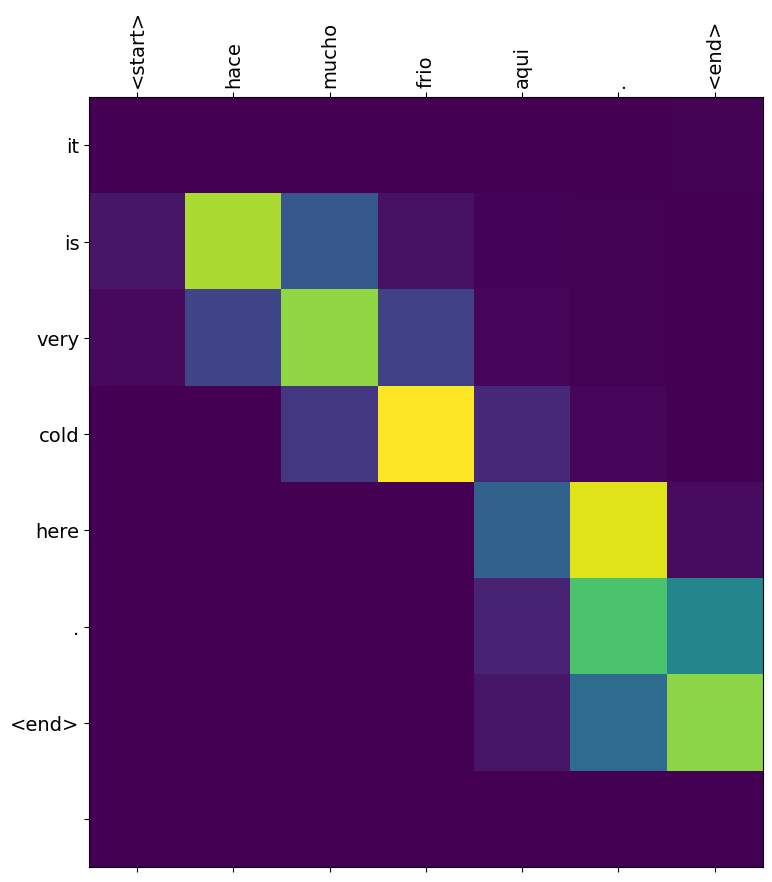

In [ ]:
translate(u'hace mucho frio aqui.')

Input: <start> esta es mi vida . <end>
Predicted translation: this is my life . <end> 


<ipython-input-29-d95136c281f7>:11: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
<ipython-input-29-d95136c281f7>:12: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)


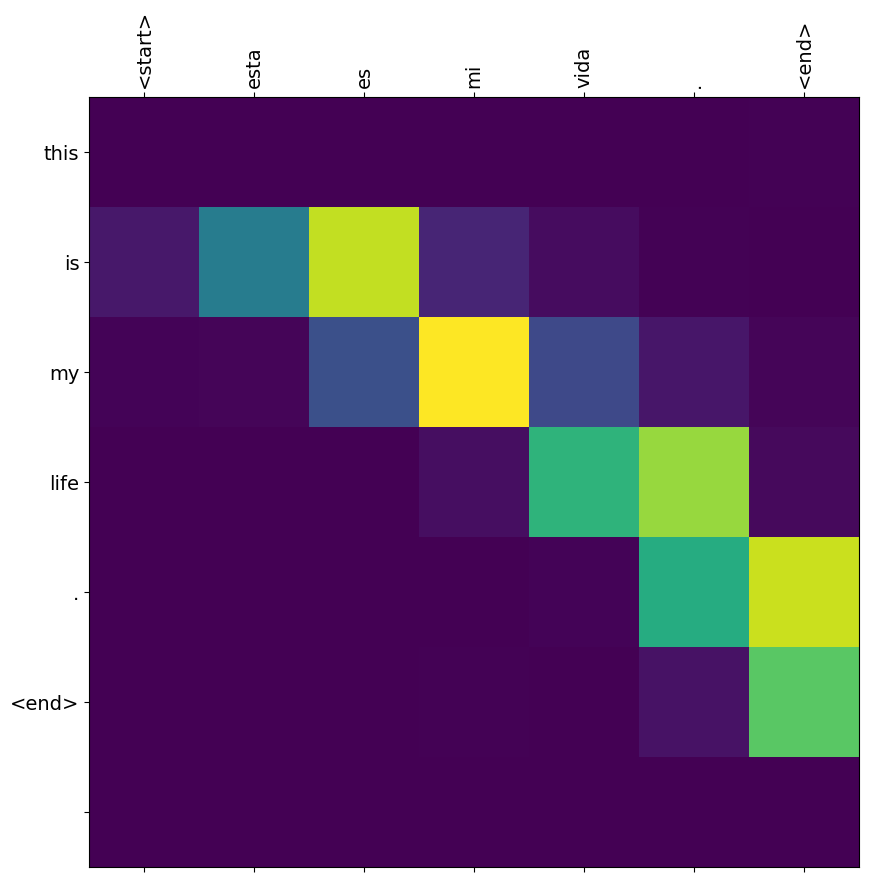

In [ ]:
translate(u'esta es mi vida.')

Input: <start> ¿ todavia estan en casa ? <end>
Predicted translation: are you still at home ? <end> 


<ipython-input-29-d95136c281f7>:11: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
<ipython-input-29-d95136c281f7>:12: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)


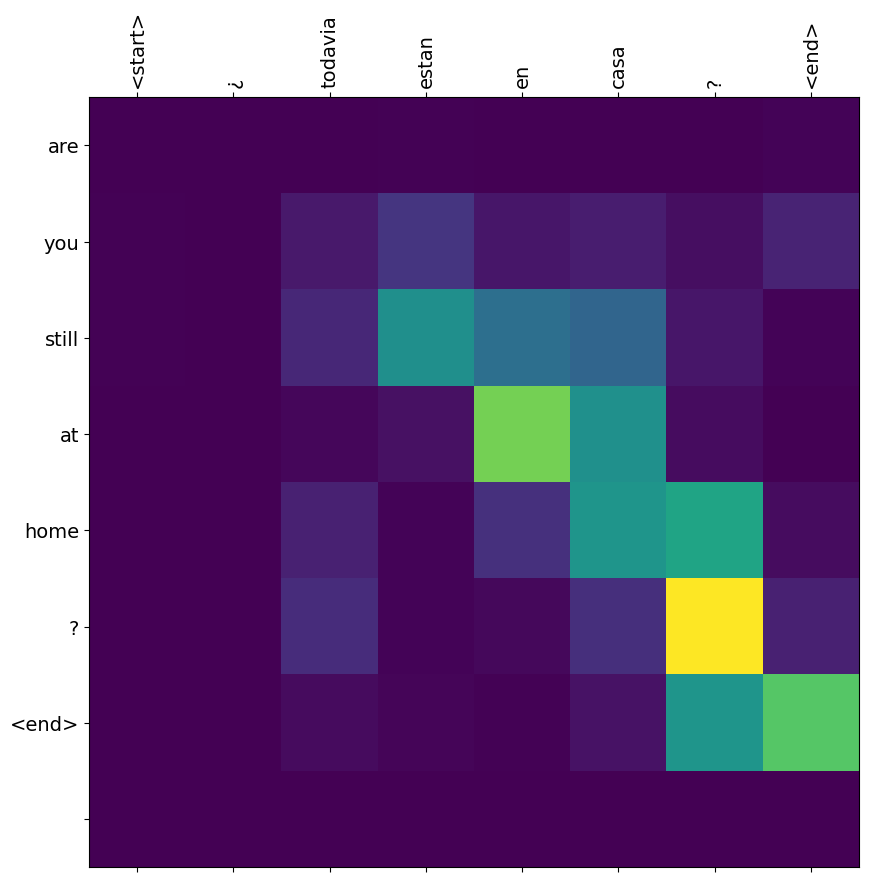

In [ ]:
translate(u'¿todavia estan en casa?')

Input: <start> trata de averiguarlo . <end>
Predicted translation: try to figure it out . <end> 


<ipython-input-29-d95136c281f7>:11: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
<ipython-input-29-d95136c281f7>:12: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)


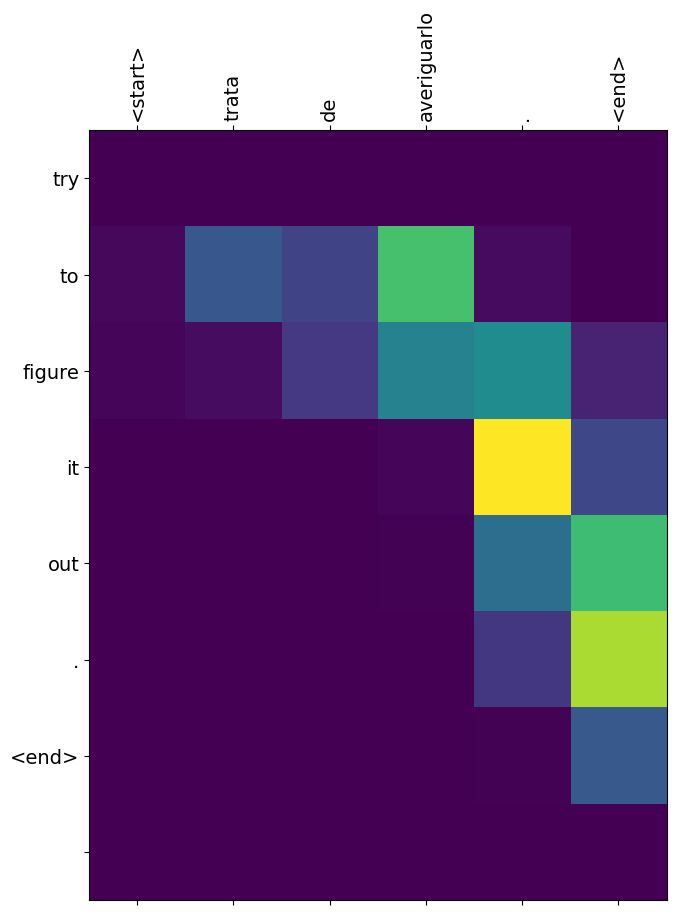

In [ ]:
# 잘못된 번역
translate(u'trata de averiguarlo.')

## 다음 단계 (영어-한국어 데이터셋)

* 앞서 영어-스페인어 데이터셋을 이용해 모델을 훈련하였습니다. 이제 영어-프랑스어, 영어-한국어 등의 [댜양한 다른 언어 데이터셋](http://www.manythings.org/anki/)을 활용하여 모델을 훈련시켜 봅시다
* 또한 이 예제에서는 데이터셋을 제한하여 모델을 만들어 보았습니다. 이제 더 많은 데이터셋 혹은 더 많은 에포크(epochs)를 적용하여 모델을 훈련해봅시다


In [ ]:
import pandas as pd

In [ ]:
def preprocess_sentence(w):
    w = w.lower().strip()

    # 단어와 단어 뒤에 오는 구두점(.) 사이에 공백을 생성
    # 예시: "he is a boy." => "he is a boy ."
    # 참고: https://stackoverflow.com/questions/3645931/python-padding-punctuation-with-white-spaces-keeping-punctuation
    w = re.sub(r"([?.!,¿])", r" \1 ", w)
    # 하나 이상의 공백이나 쌍따옴표는 단일 공백으로 변환
    w = re.sub(r'[" "]+', " ", w)
    w = re.sub(r"[^a-zA-Zㄱ-ㅎㅏ-ㅣ가-힣?.!,¿]+", " ", w)
    w = w.strip()

    # 모델이 예측을 시작하거나 중단할 때를 알게 하기 위해서
    # 문장에 start와 end 토큰을 추가합니다.
    w = '<start> ' + w + ' <end>'
    return w

In [ ]:
def create_dataset(path, num_examples):
    # 파일의 내용을 줄 단위로 나눈다
    lines = io.open(path, encoding='UTF-8').read().strip().split('\n')

    word_pairs = [[preprocess_sentence(w) for w in l.split('\t')[:2]] for l in lines[:num_examples]]

    return zip(*word_pairs)

In [ ]:
en, ko = create_dataset('/content/drive/MyDrive/KUBIG/Basic Study NLP/Week3/kor-eng.zip (Unzipped Files)/kor.txt', None)
print(en[1])
print(ko[1])

<start> hi . <end>
<start> 안녕 . <end>


In [ ]:
def tokenize(lang):
    # Tokenizer 객체 생성
    # 기본 필터링 (문장 부호 제거 등)을 비활성화
    lang_tokenizer = tf.keras.preprocessing.text.Tokenizer(filters='')
    # Tokenizer 학습
    lang_tokenizer.fit_on_texts(lang)
    # 텍스트를 시퀀스로 변환
    tensor = lang_tokenizer.texts_to_sequences(lang)
    # 시퀀스 패딩
    tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor, padding='post')

    return tensor, lang_tokenizer

In [ ]:
def load_dataset(path, num_examples=None):
    # 전처리된 타겟 문장과 입력 문장 쌍을 생성
    targ_lang, inp_lang = create_dataset(path, num_examples)

    input_tensor, inp_lang_tokenizer = tokenize(inp_lang)
    target_tensor, targ_lang_tokenizer = tokenize(targ_lang)

    return input_tensor, target_tensor, inp_lang_tokenizer, targ_lang_tokenizer

In [ ]:
path_to_file = '/content/drive/MyDrive/KUBIG/Basic Study NLP/Week3/kor-eng.zip (Unzipped Files)/kor.txt'
input_tensor, target_tensor, inp_lang, targ_lang = load_dataset(path_to_file)

# 타겟 텐서와 입력 텐서의 최대 길이를 계산합니다.
max_length_targ, max_length_inp = target_tensor.shape[1], input_tensor.shape[1]

In [ ]:
print(target_tensor.shape)
print(input_tensor.shape)

(5890, 112)
(5890, 97)


In [ ]:
# 훈련 집합과 검증 집합을 80대 20으로 분리합니다.
input_tensor_train, input_tensor_val, target_tensor_train, target_tensor_val = train_test_split(input_tensor, target_tensor, test_size=0.2)

# 훈련 집합과 검증 집합의 데이터 크기를 출력합니다.
print(len(input_tensor_train), len(target_tensor_train), len(input_tensor_val), len(target_tensor_val))

4712 4712 1178 1178


In [ ]:
def convert(lang, tensor):
    for t in tensor:
        # 실제 단어에 해당하는 인덱스인 경우, 인덱스와 해당 단어를 출력
        if t != 0:
            print ("%d ----> %s" % (t, lang.index_word[t]))

In [ ]:
print ("Input Language; index to word mapping")
convert(inp_lang, input_tensor_train[0])
print ()
print ("Target Language; index to word mapping")
convert(targ_lang, target_tensor_train[0])

Input Language; index to word mapping
1 ----> <start>
37 ----> 우리
5130 ----> 반은
5131 ----> 남자애
5132 ----> 명으로
583 ----> 구성되어
7 ----> 있어
3 ----> .
2 ----> <end>

Target Language; index to word mapping
1 ----> <start>
149 ----> our
331 ----> class
989 ----> consists
26 ----> of
713 ----> boys
3 ----> .
2 ----> <end>


In [ ]:
# 데이터셋을 섞을 때 사용되는 버퍼의 크기
BUFFER_SIZE = len(input_tensor_train)
BATCH_SIZE = 64
steps_per_epoch = len(input_tensor_train) // BATCH_SIZE
embedding_dim = 256
units = 512
# +1 : 패딩 토큰을 위한 추가 인덱스 포함
vocab_inp_size = len(inp_lang.word_index) + 1
vocab_tar_size = len(targ_lang.word_index) + 1

# tf.data.Dataset 객체로 변환
# 데이터셋의 각 요소가 튜플 (입력 텐서, 타겟 텐서)로 이루어진 형태
# BUFFER_SIZE로 전체 데이터셋을 섞고, 이 버퍼에 모든 데이터를 저장
dataset = tf.data.Dataset.from_tensor_slices((input_tensor_train, target_tensor_train)).shuffle(BUFFER_SIZE)
# 배치 크기로 데이터를 나누기
# drop_remainder=True: 마지막 배치가 배치 크기보다 작으면 이 배치를 버린다
dataset = dataset.batch(BATCH_SIZE, drop_remainder=True)

In [ ]:
# iter(dataset): dataset 객체를 반복 가능한 객체로 변환
# next: 데이터셋의 첫 번째 배치를 가져온다
example_input_batch, example_target_batch = next(iter(dataset))
example_input_batch.shape, example_target_batch.shape

(TensorShape([64, 97]), TensorShape([64, 112]))

In [ ]:
class Encoder(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, enc_units, batch_sz):
        super(Encoder, self).__init__()
        self.batch_sz = batch_sz  # batch size
        self.enc_units = enc_units  # GRU 셀의 hidden state 차원 수

        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        self.gru = tf.keras.layers.GRU(self.enc_units,
                                       return_sequences=True,  # 시퀀스의 모든 timestep 출력 반환
                                       return_state=True,  # 최종 상태 반환
                                       recurrent_initializer='glorot_uniform')  #GRU 가중치 초기화

    def call(self, x, hidden):  # hidden: 초기 hidden state
        x = self.embedding(x)
        # output: 인코더의 출력 시퀀스 (각 단어의 hidden state를 모은 것)
        # state: 인코더의 최종 hidden state
        output, state = self.gru(x, initial_state = hidden)
        return output, state

    # GRU 셀의 초기 hidden state 생성
    def initialize_hidden_state(self):
        return tf.zeros((self.batch_sz, self.enc_units))

In [ ]:
encoder = Encoder(vocab_inp_size, embedding_dim, units, BATCH_SIZE)

# 샘플 입력
sample_hidden = encoder.initialize_hidden_state()
sample_output, sample_hidden = encoder(example_input_batch, sample_hidden)
print ('Encoder output shape: (batch size, sequence length, units) {}'.format(sample_output.shape))
print ('Encoder Hidden state shape: (batch size, units) {}'.format(sample_hidden.shape))

Encoder output shape: (batch size, sequence length, units) (64, 97, 512)
Encoder Hidden state shape: (batch size, units) (64, 512)


In [ ]:
class BahdanauAttention(tf.keras.layers.Layer):
    def __init__(self, units):
        super(BahdanauAttention, self).__init__()
        self.W1 = tf.keras.layers.Dense(units)
        self.W2 = tf.keras.layers.Dense(units)
        self.V = tf.keras.layers.Dense(1)

    def call(self, query, values):
        # 쿼리 은닉 상태(query hidden state)는 (batch_size, hidden size)쌍으로 이루어져 있습니다.
        # query_with_time_axis은 (batch_size, 1, hidden size)쌍으로 이루어져 있습니다.
        # values는 (batch_size, max_len, hidden size)쌍으로 이루어져 있습니다.
        # 스코어(score)계산을 위해 덧셈을 수행하고자 시간 축을 확장하여 아래의 과정을 수행합니다.
        query_with_time_axis = tf.expand_dims(query, 1)

        # score는 (batch_size, max_length, 1)쌍으로 이루어져 있습니다.
        # score를 self.V에 적용하기 때문에 마지막 축에 1을 얻습니다.
        # self.V에 적용하기 전에 텐서는 (batch_size, max_length, units)쌍으로 이루어져 있습니다.
        score = self.V(tf.nn.tanh(
                       self.W1(query_with_time_axis) + self.W2(values)))

        # attention_weights는 (batch_size, max_length, 1)쌍으로 이루어져 있습니다.
        attention_weights = tf.nn.softmax(score, axis=1)

        # 덧셈이후 컨텍스트 벡터(context_vector)는 (batch_size, hidden_size)쌍으로 이루어져 있습니다.
        context_vector = attention_weights * values
        context_vector = tf.reduce_sum(context_vector, axis=1)

        return context_vector, attention_weights

In [ ]:
attention_layer = BahdanauAttention(1024)
attention_result, attention_weights = attention_layer(sample_hidden, sample_output)

print("Attention result shape: (batch size, units) {}".format(attention_result.shape))
print("Attention weights shape: (batch_size, sequence_length, 1) {}".format(attention_weights.shape))

Attention result shape: (batch size, units) (64, 512)
Attention weights shape: (batch_size, sequence_length, 1) (64, 97, 1)


In [ ]:
class Decoder(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, dec_units, batch_sz):
        super(Decoder, self).__init__()
        self.batch_sz = batch_sz
        self.dec_units = dec_units  # GRU 셀의 hidden state 차원 수

        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        self.gru = tf.keras.layers.GRU(self.dec_units,
                                    return_sequences=True,
                                    return_state=True,
                                    recurrent_initializer='glorot_uniform')
        self.fc = tf.keras.layers.Dense(vocab_size)

        # 어텐션을 사용합니다.
        self.attention = BahdanauAttention(self.dec_units)


    def call(self, x, hidden, enc_output):
        # enc_output는 (batch_size, max_length, hidden_size)쌍으로 이루어져 있습니다.
        context_vector, attention_weights = self.attention(hidden, enc_output)

        # 임베딩층을 통과한 후 x는 (batch_size, 1, embedding_dim)쌍으로 이루어져 있습니다.
        x = self.embedding(x)

        # 컨텍스트 벡터와 임베딩 결과를 결합한 이후 x의 형태는 (batch_size, 1, embedding_dim + hidden_size)쌍으로 이루어져 있습니다.
        x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1)

        # 위에서 결합된 벡터를 GRU에 전달합니다.
        output, state = self.gru(x)

        # output은 (batch_size * 1, hidden_size)쌍으로 이루어져 있습니다.
        output = tf.reshape(output, (-1, output.shape[2]))

        # output은 (batch_size, vocab)쌍으로 이루어져 있습니다.
        x = self.fc(output)

        return x, state, attention_weights

In [ ]:
decoder = Decoder(vocab_tar_size, embedding_dim, units, BATCH_SIZE)

sample_decoder_output, _, _ = decoder(tf.random.uniform((BATCH_SIZE, 1)),
                                      sample_hidden, sample_output)

print ('Decoder output shape: (batch_size, vocab size) {}'.format(sample_decoder_output.shape))

Decoder output shape: (batch_size, vocab size) (64, 3113)


In [ ]:
optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
              from_logits=True,  # 예측값이 softmax 적용 전의 raw logits
              reduction='none')  # 배치 내 각 샘플의 손실을 개별적으로 계산하여 반환

def loss_function(real, pred):
    # 실제 레이블이 0(패딩 토큰)이 아닌 경우를 찾기 위해 마스크를 생성
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    # 각 샘플에 대해 손실 계산
    loss_ = loss_object(real, pred)

    # 패딩 토큰에 해당하는 손실을 무시
    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask

    # 배치 내 모든 샘플의 평균 손실을 반환
    return tf.reduce_mean(loss_)

In [ ]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(optimizer=optimizer,
                                 encoder=encoder,
                                 decoder=decoder)

In [ ]:
# 이 함수를 텐서플로우의 계산 그래프로 변환하여 성능을 최적화
@tf.function
# inp: 입력 데이터
# targ: 타겟 데이터
# enc_hidden: 초기 encoder hidden state
def train_step(inp, targ, enc_hidden):
    loss = 0

    # 자동 미분을 위해 gradient를 기록
    with tf.GradientTape() as tape:
        enc_output, enc_hidden = encoder(inp, enc_hidden)

        # decoder의 초기 hidden state를 encoder의 마지막 hidden state로 설정
        dec_hidden = enc_hidden
        # decoder의 초기 입력은 <start> 토큰
        dec_input = tf.expand_dims([targ_lang.word_index['<start>']] * BATCH_SIZE, 1)

        # 교사 강요(teacher forcing) - 다음 입력으로 target을 피딩(feeding)합니다.
        for t in range(1, targ.shape[1]):
            # target 시퀀스의 각 timestep에 대해 decoder를 호출하여 예측값, 새로운 디코더 은닉 상태를 얻음
            predictions, dec_hidden, _ = decoder(dec_input, dec_hidden, enc_output)
            # 손실 계산
            loss += loss_function(targ[:, t], predictions)
            # 교사 강요를 사용해, 다음 timestep의 입력으로 실제 target 값을 사용
            dec_input = tf.expand_dims(targ[:, t], 1)
    # 배치 손실: 전체 손실 / timestep 수
    batch_loss = (loss / int(targ.shape[1]))
    # encoder와 decoder의 학습 가능한 변수들 결합
    variables = encoder.trainable_variables + decoder.trainable_variables
    # gradient 계산
    gradients = tape.gradient(loss, variables)
    # optimizer 사용하여 모델의 매개변수 업데이트
    optimizer.apply_gradients(zip(gradients, variables))

    return batch_loss

In [ ]:
EPOCHS = 10

for epoch in range(EPOCHS):
    start = time.time()

    enc_hidden = encoder.initialize_hidden_state()
    total_loss = 0

    for (batch, (inp, targ)) in enumerate(dataset.take(steps_per_epoch)):
        batch_loss = train_step(inp, targ, enc_hidden)
        total_loss += batch_loss

        if batch % 100 == 0:
            print('Epoch {} Batch {} Loss {:.4f}'.format(epoch + 1,
                                                        batch,
                                                        batch_loss.numpy()))
    # 에포크가 2번 실행될 때마다 모델 저장 (체크포인트)
    if (epoch + 1) % 2 == 0:
        checkpoint.save(file_prefix = checkpoint_prefix)

    print('Epoch {} Loss {:.4f}'.format(epoch + 1,
                                        total_loss / steps_per_epoch))
    print('Time taken for 1 epoch {} sec\n'.format(time.time() - start))

Epoch 1 Batch 0 Loss 0.5745
Epoch 1 Loss 0.3788
Time taken for 1 epoch 192.714998960495 sec

Epoch 2 Batch 0 Loss 0.3206
Epoch 2 Loss 0.3203
Time taken for 1 epoch 44.48222494125366 sec

Epoch 3 Batch 0 Loss 0.3366
Epoch 3 Loss 0.2942
Time taken for 1 epoch 43.84892535209656 sec

Epoch 4 Batch 0 Loss 0.2875
Epoch 4 Loss 0.2671
Time taken for 1 epoch 43.71246838569641 sec

Epoch 5 Batch 0 Loss 0.2296
Epoch 5 Loss 0.2462
Time taken for 1 epoch 43.46829128265381 sec

Epoch 6 Batch 0 Loss 0.2491
Epoch 6 Loss 0.2312
Time taken for 1 epoch 43.704339027404785 sec

Epoch 7 Batch 0 Loss 0.2245
Epoch 7 Loss 0.2175
Time taken for 1 epoch 43.612508058547974 sec

Epoch 8 Batch 0 Loss 0.2148
Epoch 8 Loss 0.2046
Time taken for 1 epoch 44.034236907958984 sec

Epoch 9 Batch 0 Loss 0.1778
Epoch 9 Loss 0.1925
Time taken for 1 epoch 43.48289918899536 sec

Epoch 10 Batch 0 Loss 0.1738
Epoch 10 Loss 0.1803
Time taken for 1 epoch 43.7202935218811 sec



In [ ]:
def evaluate(sentence):
    # attention weight 저장할 배열을 초기화
    attention_plot = np.zeros((max_length_targ, max_length_inp))

    # 입력 문장 전처리
    sentence = preprocess_sentence(sentence)
    # 토큰화
    inputs = [inp_lang.word_index[i] for i in sentence.split(' ')]
    # 패딩
    inputs = tf.keras.preprocessing.sequence.pad_sequences([inputs],
                                                            maxlen=max_length_inp,
                                                            padding='post')
    inputs = tf.convert_to_tensor(inputs)

    result = ''
    # encoder의 초기 hidden state를 0으로 설정
    hidden = [tf.zeros((1, units))]
    enc_out, enc_hidden = encoder(inputs, hidden)
    dec_hidden = enc_hidden
    # decoder의 첫 번째 입력을 start 토큰으로 설정
    dec_input = tf.expand_dims([targ_lang.word_index['<start>']], 0)

    for t in range(max_length_targ):
        predictions, dec_hidden, attention_weights = decoder(dec_input,
                                                            dec_hidden,
                                                            enc_out)

        # attention weight을 (N * T * 1) 1차원으로 변형
        attention_weights = tf.reshape(attention_weights, (-1, ))
        # attention weight을 attention plot의 각 행에 저장
        attention_plot[t] = attention_weights.numpy()
        # decoder의 예측 결과에서 가장 높은 확률을 가진 단어의 ID를 선택
        predicted_id = tf.argmax(predictions[0]).numpy()
        # 예측된 단어를 결과 문자열에 추가
        result += targ_lang.index_word[predicted_id] + ' '
        # 예측된 단어가 종료 토큰일 경우 결과를 반환
        if targ_lang.index_word[predicted_id] == '<end>':
            return result, sentence, attention_plot

        # 예측된 ID를 모델에 다시 피드합니다.
        dec_input = tf.expand_dims([predicted_id], 0)

    return result, sentence, attention_plot

In [ ]:
# 어텐션 가중치를 그리기 위한 함수
def plot_attention(attention, sentence, predicted_sentence):
    fig = plt.figure(figsize=(10,10))
    # 1x1 서브플롯
    ax = fig.add_subplot(1, 1, 1)
    # 히트맵으로 시각화
    ax.matshow(attention, cmap='viridis')

    fontdict = {'fontsize': 14}

    ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
    ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)
    # x, y 축 간격을 1로 설정
    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()

In [ ]:
def translate(sentence):
    result, sentence, attention_plot = evaluate(sentence)

    print('Input: %s' % (sentence))
    print('Predicted translation: {}'.format(result))

    # 어텐션 가중치 행렬을 결과 문장과 입력 문장 길이에 맞게 자른다. > 시각화 명확
    attention_plot = attention_plot[:len(result.split(' ')), :len(sentence.split(' '))]
    plot_attention(attention_plot, sentence.split(' '), result.split(' '))

Input: <start> 나는 일하는 게 싫다 . <end>
Predicted translation: i think tom is a age . <end> 


<ipython-input-34-d95136c281f7>:11: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
<ipython-input-34-d95136c281f7>:12: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)


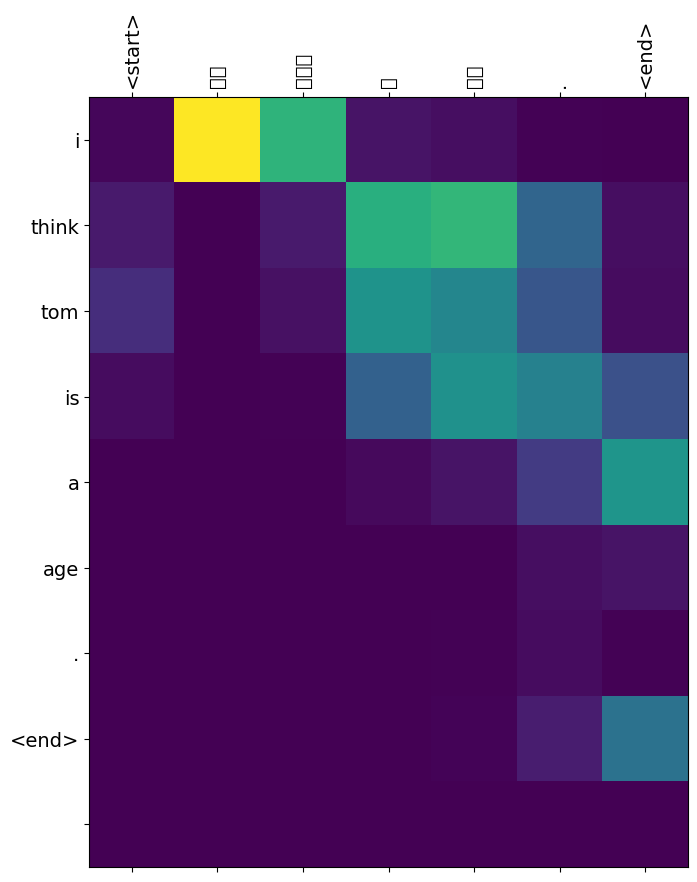

In [ ]:
translate('나는 일하는 게 싫다.')

Input: <start> 이 케이크는 달다 . <end>
Predicted translation: this is your hands . <end> 


<ipython-input-34-d95136c281f7>:11: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
<ipython-input-34-d95136c281f7>:12: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 51060 (\N{HANGUL SYLLABLE I}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 52992 (\N{HANGUL SYLLABLE KE}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 53356 (\N{HANGUL SYLLABLE KEU}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:1

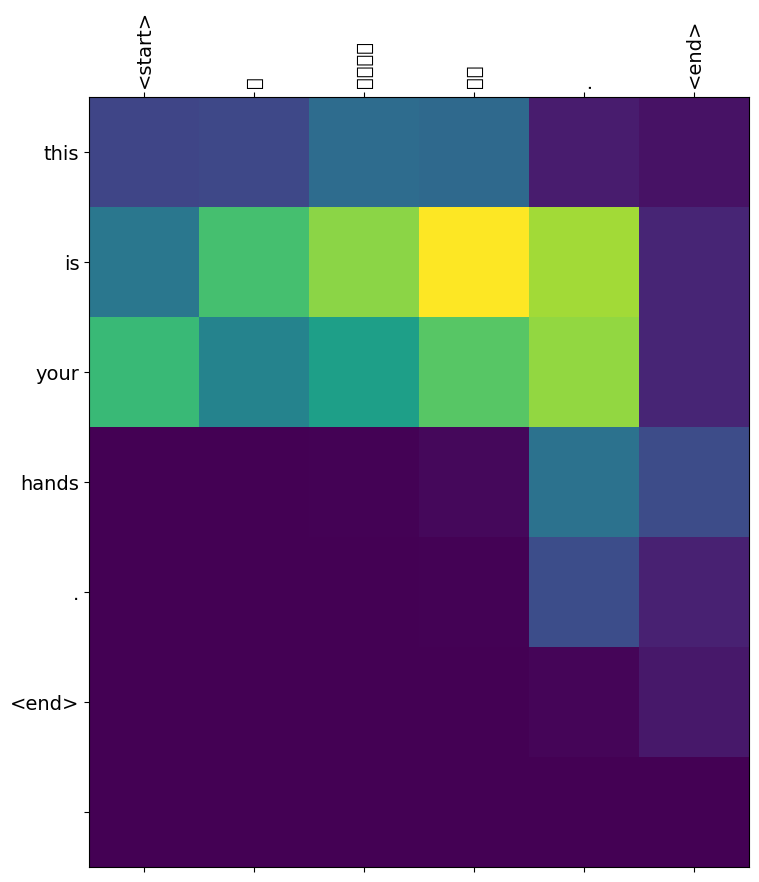

In [ ]:
translate('이 케이크는 달다.')

Input: <start> 이 방은 너무 커요 . <end>
Predicted translation: it s not a lot of my favorite beautiful . <end> 


<ipython-input-34-d95136c281f7>:11: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
<ipython-input-34-d95136c281f7>:12: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 48169 (\N{HANGUL SYLLABLE BANG}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 51008 (\N{HANGUL SYLLABLE EUN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 45320 (\N{HANGUL SYLLABLE NEO}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.

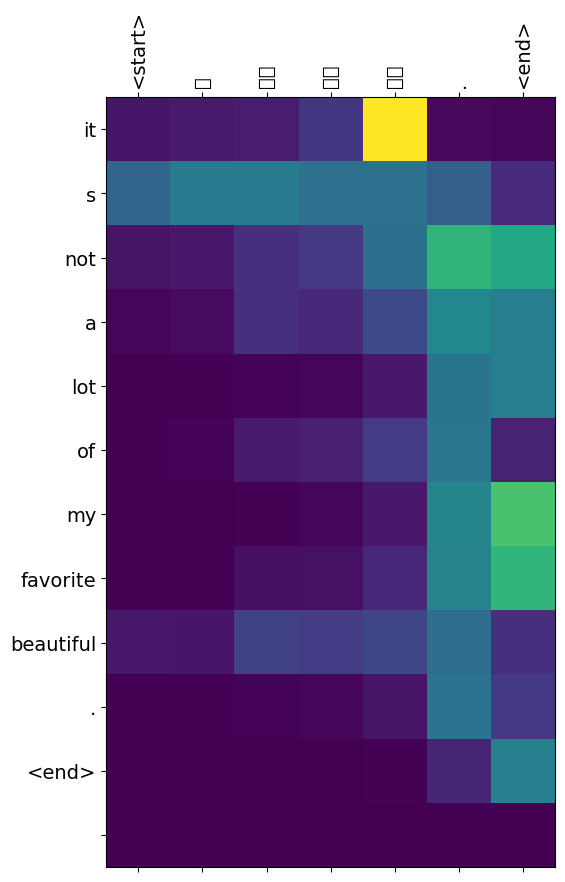

In [ ]:
translate('이 방은 너무 커요.')